# Evaluation
## Heuristic
Run heuristic solver by providing name of heuristic solver to benchmark.sh as argument e.g.

./instances/benchmark.sh "python3 ../code/heuristic.py"

Results will be saved to instances/results-date.csv. Let's load the results and plot the solution quality and running time.

In [1]:
import csv

reults_file_name = "../test-instances/results-2024-07-02-17-17-02.csv"
data = {}
with open(reults_file_name) as file:
    for row in csv.DictReader(file, delimiter=';'):
        instance = row['file'].split('/')[-1].split('.')[0]
        time = row['time']
        if row['solsize'] != "":
            sol_size = int(row['solsize'])
        if "BAD COST" in row['verified']:
            bad_cost = int(row[None][0])
        else:
            bad_cost = 0
        data.update({instance: [sol_size, bad_cost, time]})

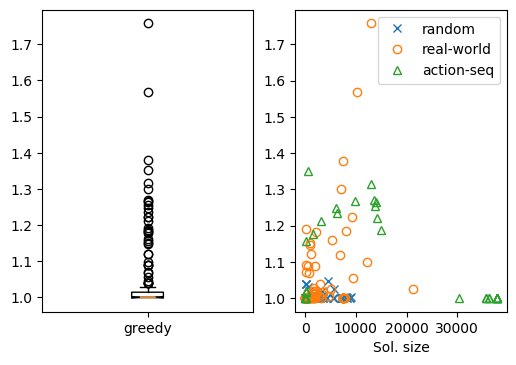

Greedy: Mean 3.864%


In [3]:
from matplotlib import pyplot as plt
import numpy as np

heuristic = "greedy"
rrel_errors, wrel_errors, arel_errors = [], [], []
rsol_sizes, wsol_sizes, asol_sizes = [], [], []
for instance, result in data.items():
    if result[0] != 0:
        if instance.startswith('r'):
            rsol_sizes.append(result[0])
            rrel_errors.append((result[0] + result[1])/result[0])
        if instance.startswith('w'):
            wsol_sizes.append(result[0])
            wrel_errors.append((result[0] + result[1])/result[0])
        if instance.startswith('a'):
            asol_sizes.append(result[0])
            arel_errors.append((result[0] + result[1])/result[0])

fig, (ax0, ax1) = plt.subplots(1,2, dpi=100)

ax0.boxplot(rrel_errors + wrel_errors + arel_errors, notch=True, labels=[heuristic])
ax1.plot(rsol_sizes, rrel_errors, 'x', label="random")
ax1.plot(wsol_sizes, wrel_errors, 'o', mfc='none', label="real-world")
ax1.plot(asol_sizes, arel_errors, '^', mfc='none', label="action-seq")
ax1.legend()
ax1.set_xlabel("Sol. size")

plt.show()
print("Greedy: Mean %.3f%%" % ((np.mean(rrel_errors + wrel_errors + arel_errors)-1)*100))

## Lower Bounds
LP-Relaxation bound

In [4]:
import os, sys
sys.path.append(os.path.join("..", "code"))
from ilp_solver import LPSolver
from graph import Graph
from parse import parse_input_file

datasets = ["1-random", "2-real-world", "3-actionseq"]
for dataset in datasets:
    d_path = os.path.join("..", "test-instances", dataset)
    for file in os.listdir(d_path):
        if file.endswith(".dimacs"):
            weights = parse_input_file(os.path.join(d_path, file))
            graph = Graph(weights)
            #solver = LPSolver(graph)
            #solver.setup()
            #solution = solver.solve()
            #print(solution)

## Reduction Rules

In [52]:
import reductionrules as rr
from graph import Graph

reductionrules = [rr.heavy_edge_single_end_exhaustive, rr.heavy_edge_both_ends_exhaustive]
rr_reductions = []

datasets = ["1-random", "2-real-world", "3-actionseq"]
solutions = {dataset: {} for dataset in datasets}
for dataset in datasets:
    for file in os.listdir(os.path.join("..", "test-instances", dataset)):
        if file.endswith(".dimacs.solution"):
            with open(os.path.join("..", "test-instances", dataset, file), 'r') as f:
                solution = f.readline()
                try:
                    solutions[dataset].update({file[:-16]: int(solution)})
                except:
                    continue

for r, rule in enumerate(reductionrules):
    print(r)
    reducedks, reducedvs = {}, {}
    for dataset in datasets:
        print(dataset)
        d_path = os.path.join("..", "test-instances", dataset)
        for file in os.listdir(d_path):
            if file.endswith(".dimacs"):
                weights = parse_input_file(os.path.join(d_path, file))
                graph = Graph(weights)
                orig_vertices = len(graph.get_vertices())
                merged, d = rule(graph)
                vertices = len(graph.get_vertices())
                reducedvs.update({file: (orig_vertices - vertices)/orig_vertices})
                try:
                    sol = solutions[dataset][file[:-7]]
                    if sol != 0:
                        reducedks.update({file: d/sol})
                except:
                    continue
    rr_reductions.append((reducedvs, reducedks))

0
1-random
2-real-world
3-actionseq
1
1-random
2-real-world
3-actionseq


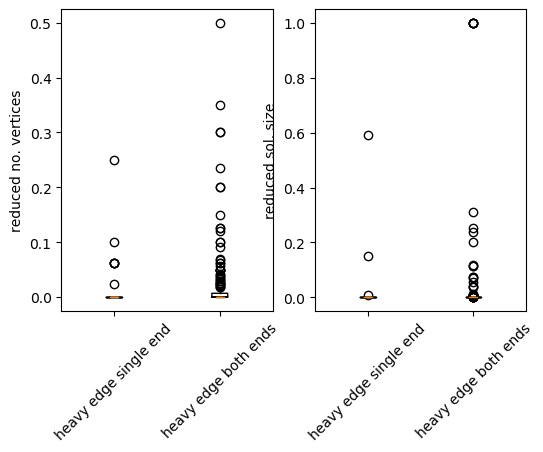

In [53]:
fig, (ax0, ax1) = plt.subplots(1,2, dpi=100)

reducedvs = [list(rr_reductions[r][0].values()) for r in range(len(reductionrules))]
ax0.boxplot(np.array(reducedvs).T, notch=True)
ax0.set_xticklabels(["heavy edge single end", "heavy edge both ends"], rotation=45)
ax0.set_ylabel("reduced no. vertices")

reducedks = [list(rr_reductions[r][1].values()) for r in range(len(reductionrules))]
ax1.boxplot(np.array(reducedks).T, notch=True)
ax1.set_xticklabels(["heavy edge single end", "heavy edge both ends"], rotation=45)
ax1.set_ylabel("reduced sol. size")

plt.show()